In [1]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/deep_al/results/udal/ results
ls results

active_learning
evaluation
hparams
synthetic


In [3]:

def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    exp_checkpoint = path / 'model_final.pth'

    if exp_cfg.is_file():
        cfg =  OmegaConf.load(exp_cfg)
        results['cfg'] = cfg
    else:
        raise ValueError(f'Config missing for {exp_cfg}')

    if exp_json.is_file():
        data = load_json(exp_json)
        results['results'] = data
    else:
        raise ValueError(f'Results missing for {exp_json}')

    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    for exp_path in result_path.glob(glob_pattern):
        print('> Found', exp_path)
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'results/active_learning/CIFAR10/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/'
exp_results = get_experiments(Path(path), 'seed1')
# metrics = get_metric_values(exp_results)
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['train_history'][-1].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in results/active_learning/CIFAR10/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/CIFAR10/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
dict_keys(['train_history', 'test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['train_lr', 'train_loss', 'train_acc1'])
dict_keys(['test_acc1', 'test_loss', 'test_nll', 'test_brier', 'test_tce', 'test_mce', 'test_CIFAR100_auroc', 'test_CIFAR100_aupr', 'test_SVHN_auroc', 'test_SVHN_aupr'])


## Aleatoric Results

In [12]:
dataset = 'SVHN'
model = 'resnet18'
experiments = {}
num_cycles = 19
# Deterministic
experiments.update({
    # 'random': f'results/active_learning/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'random eval': f'results/evaluation/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    # 'least conf': f'results/active_learning/{dataset}/resnet18/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'least conf eval': f'results/evaluation/{dataset}/resnet18/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    # 'margin': f'results/active_learning/{dataset}/resnet18/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'margin eval': f'results/evaluation/{dataset}/resnet18/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    # 'entropy': f'results/active_learning/{dataset}/resnet18/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'entropy eval': f'results/evaluation/{dataset}/resnet18/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
})

# Labels smoothing
experiments.update({
    'random (ls)': f'results/active_learning/{dataset}/resnet18_labelsmoothing/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'random (ls) eval': f'results/evaluation/{dataset}/resnet18_labelsmoothing/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'least conf (ls)': f'results/active_learning/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'least conf (ls) eval ': f'results/evaluation/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'margin (ls)': f'results/active_learning/{dataset}/resnet18_labelsmoothing/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'margin (ls) eval': f'results/evaluation/{dataset}/resnet18_labelsmoothing/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'entropy (ls)': f'results/active_learning/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy (ls) eval': f'results/evaluation/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
})

# Mixup
experiments.update({
    'random (mixup)': f'results/active_learning/{dataset}/resnet18_mixup/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'random (mixup) eval': f'results/evaluation/{dataset}/resnet18_mixup/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'least conf (mixup)': f'results/active_learning/{dataset}/resnet18_mixup/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'least (mixup) conf eval': f'results/evaluation/{dataset}/resnet18_mixup/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'margin (mixup)': f'results/active_learning/{dataset}/resnet18_mixup/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'margin (mixup) eval': f'results/evaluation/{dataset}/resnet18_mixup/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'entropy (mixup)': f'results/active_learning/{dataset}/resnet18_mixup/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    'entropy (mixup) eval': f'results/evaluation/{dataset}/resnet18_mixup/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/20 [00:00<?, ?it/s]

Searching in results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5


  5%|▌         | 1/20 [00:04<01:25,  4.50s/it]

Searching in results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18/least_conf

 10%|█         | 2/20 [00:05<00:47,  2.66s/it]

Searching in results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2


 15%|█▌        | 3/20 [00:10<00:59,  3.47s/it]

Searching in results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6


 20%|██        | 4/20 [00:14<01:02,  3.92s/it]

Searching in results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_l

 25%|██▌       | 5/20 [00:19<01:00,  4.05s/it]

Searching in results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_labelsmoothing/random/N_INIT100__ACQ_SIZE100__N_ACQ

 30%|███       | 6/20 [00:23<00:56,  4.02s/it]

Searching in results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_IN

 35%|███▌      | 7/20 [00:24<00:42,  3.26s/it]

> Found results/active_learning/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
Searching in results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Foun

 40%|████      | 8/20 [00:26<00:32,  2.75s/it]

> Found results/evaluation/SVHN/resnet18_labelsmoothing/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
Searching in results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet

 45%|████▌     | 9/20 [00:31<00:36,  3.30s/it]

Searching in results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_labelsmoothing/margin/N_INIT100__ACQ_SIZE100__N_ACQ

 50%|█████     | 10/20 [00:35<00:37,  3.71s/it]

Searching in results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/r

 55%|█████▌    | 11/20 [00:40<00:35,  3.94s/it]

Searching in results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_labelsmoothing/entropy/N_INIT100__ACQ_SIZE

 60%|██████    | 12/20 [00:44<00:31,  3.97s/it]

Searching in results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning

 65%|██████▌   | 13/20 [00:48<00:29,  4.16s/it]

Searching in results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mixup/random/N_INIT100__ACQ_SIZE100__N_A

 70%|███████   | 14/20 [00:52<00:24,  4.03s/it]

Searching in results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_m

 75%|███████▌  | 15/20 [00:54<00:16,  3.29s/it]

Searching in results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mixup/least_confident/N_INIT100__ACQ_SIZE100__N_ACQ

 80%|████████  | 16/20 [00:55<00:11,  2.75s/it]

Searching in results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning

 85%|████████▌ | 17/20 [01:00<00:09,  3.33s/it]

Searching in results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mixup/margin/N_INIT100__ACQ_SIZE100__N_A

 90%|█████████ | 18/20 [01:04<00:07,  3.58s/it]

Searching in results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/activ

 95%|█████████▌| 19/20 [01:09<00:04,  4.01s/it]

Searching in results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mixup/entropy/N_INIT100__ACQ_S

100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


100%|██████████| 20/20 [00:00<00:00, 58.39it/s]


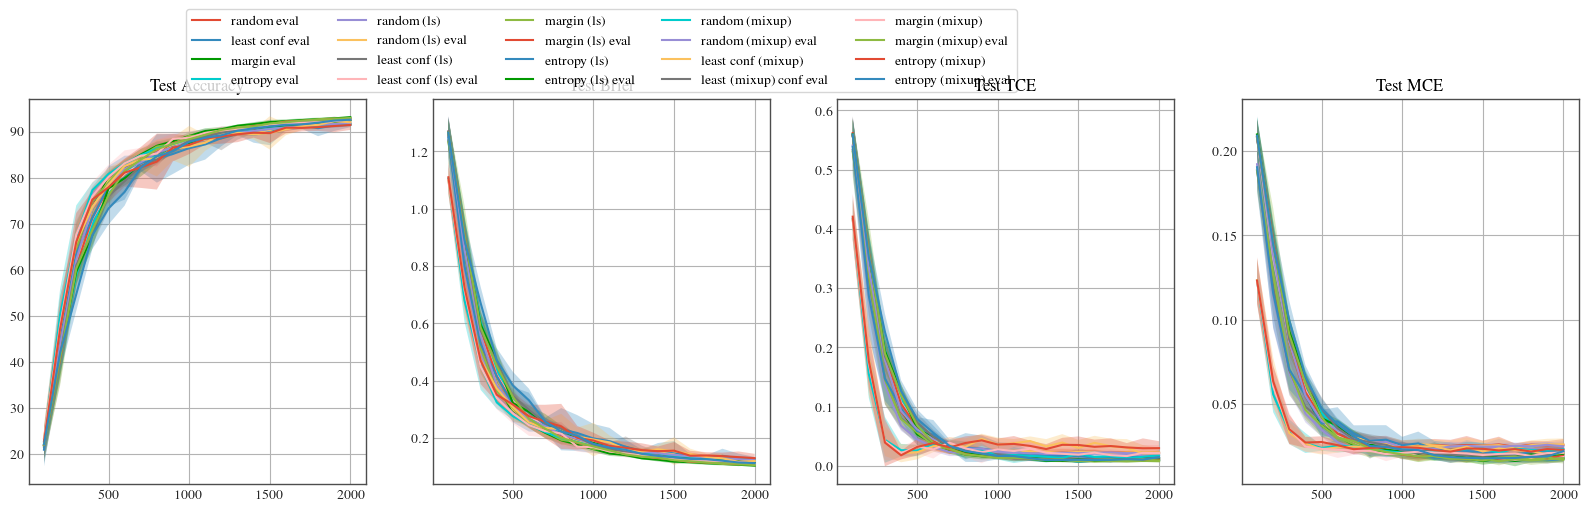

In [13]:
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_mce = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        # train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        # train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['test_brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['test_tce'] for cycle in data])
        test_mce.append([data[cycle]['test_stats']['test_mce'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    # train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    # train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_mce_mean, test_mce_std = np.mean(test_mce, 0), np.std(test_mce, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1] / 100, 
        'acc (AUC)': np.mean(test_accs_mean) / 100, 
        'nll (Final)': test_nll_mean[-1], 
        'nll (AUC)': np.mean(test_nll_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1],
        'TCE (AUC)': np.mean(test_tce_mean), 
        'MCE (Final)': test_mce_mean[-1],
        'MCE (AUC)': np.mean(test_mce_mean), 
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test MCE')
    plt.plot(n_labeled_samples, test_mce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_mce_mean-test_mce_std, test_mce_mean+test_mce_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)
        

In [3]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T.to_latex(float_format="%.3f"))

NameError: name 'table_dict' is not defined

## Epistemic Results

In [24]:
dataset = 'SVHN'
experiments = {}

# MC-Dropout
experiments.update({
    'random (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'random eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})
# Ensemble
experiments.update({
    'random (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'random eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})



all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/16 [00:00<?, ?it/s]

Searching in results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ

  6%|▋         | 1/16 [00:01<00:15,  1.02s/it]

Searching in results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4


 12%|█▎        | 2/16 [00:02<00:14,  1.03s/it]

> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
Searching in results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/

 19%|█▉        | 3/16 [00:03<00:14,  1.09s/it]

> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
Searching in results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_m

 25%|██▌       | 4/16 [00:04<00:14,  1.23s/it]

> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
Searching in results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Fo

 31%|███▏      | 5/16 [00:05<00:12,  1.16s/it]

> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
Searching in results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/

 38%|███▊      | 6/16 [00:06<00:11,  1.15s/it]

Searching in results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found res

 44%|████▍     | 7/16 [00:07<00:10,  1.15s/it]

Searching in results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mcdropout/varia

 50%|█████     | 8/16 [00:08<00:08,  1.11s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
>

 56%|█████▋    | 9/16 [00:10<00:07,  1.13s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_ensemble/r

 62%|██████▎   | 10/16 [00:11<00:06,  1.11s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found res

 69%|██████▉   | 11/16 [00:12<00:05,  1.15s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/bayesi

 75%|███████▌  | 12/16 [00:13<00:04,  1.14s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/activ

 81%|████████▏ | 13/16 [00:14<00:03,  1.18s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_S

 88%|████████▊ | 14/16 [00:16<00:02,  1.36s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/acti

 94%|█████████▍| 15/16 [00:17<00:01,  1.32s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio

100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


100%|██████████| 16/16 [00:00<00:00, 62.10it/s]


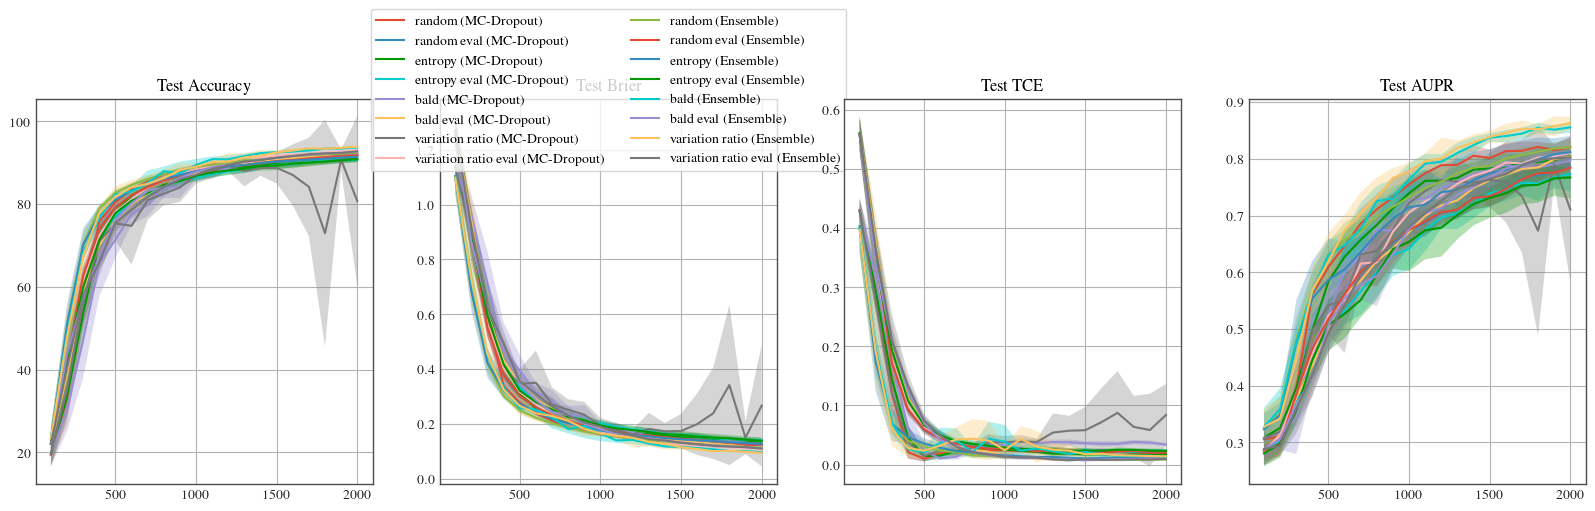

In [25]:
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_aupr_cifar10= []
    test_aupr_cifar100 = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['test_brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['test_tce'] for cycle in data])
        test_aupr_cifar10.append([data[cycle]['test_stats']['test_CIFAR10_aupr'] for cycle in data])
        test_aupr_cifar100.append([data[cycle]['test_stats']['test_CIFAR100_aupr'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_aupr_cifar100_mean, test_aupr_cifar100_std = np.mean(test_aupr_cifar100, 0), np.std(test_aupr_cifar100, 0)
    test_aupr_cifar10_mean, test_aupr_cifar10_std = np.mean(test_aupr_cifar10, 0), np.std(test_aupr_cifar10, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1] / 100, 
        'acc (AUC)': np.mean(test_accs_mean) / 100, 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1], 
        'TCE (AUC)': np.mean(test_tce_mean), 
        'AUPR CIFAR10 (Final)': test_aupr_cifar10_mean[-1],
        'AUPR CIFAR10 (AUC)': np.mean(test_aupr_cifar10_mean),
        'AUPR CIFAR100 (Final)': test_aupr_cifar100_mean[-1],
        'AUPR CIFAR100 (AUC)': np.mean(test_aupr_cifar100_mean),
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test AUPR')
    plt.plot(n_labeled_samples, test_aupr_cifar100_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_aupr_cifar100_mean-test_aupr_cifar100_std, test_aupr_cifar100_mean+test_aupr_cifar100_std, alpha=.3)
    # plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [26]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  acc (Final) &  acc (AUC) &  brier (Final) &  brier (AUC) &  TCE (Final) &  TCE (AUC) &  AUPR CIFAR10 (Final) &  AUPR CIFAR10 (AUC) &  AUPR CIFAR100 (Final) &  AUPR CIFAR100 (AUC) \\
\midrule
random (MC-Dropout)               &        0.920 &      0.804 &          0.120 &        0.279 &        0.019 &      0.060 &                 0.831 &               0.693 &                  0.821 &                0.688 \\
random eval (MC-Dropout)          &        0.919 &      0.806 &          0.125 &        0.295 &        0.021 &      0.082 &                 0.797 &               0.628 &                  0.786 &                0.624 \\
entropy (MC-Dropout)              &        0.908 &      0.790 &          0.137 &        0.299 &        0.017 &      0.061 &                 0.819 &               0.676 &                  0.805 &                0.668 \\
entropy eval (MC-Dropout)         &        0.908 &      0.791 &          0.140 &        0.316 &        0.023

/tmp/ipykernel_22410/3911846269.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.T.to_latex(float_format="%.3f"))


## Load Experiment

In [4]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model

model_name = 'resnet18_mcdropout'
strat_name = 'random'
exp_path = Path(f'results/active_learning/CIFAR10/{model_name}/{strat_name}/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/seed1')
checkpoint = torch.load(exp_path / 'checkpoint.pth')
args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')

trainer = build_model(args, n_classes=10)
model = trainer.model
model.load_state_dict(checkpoint['model'])

args.dataset_path = '/datasets'
_, _, test_ds, _ = build_datasets(args)

2023-05-02 22:12:41.242831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:12:41.894472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
results = load_json(exp_path / 'results.json')
results['cycle19']['test_stats']

{'test_acc1': 72.94999694824219,
 'test_loss': 0.9619036912918091,
 'test_nll': 0.8499259948730469,
 'test_brier': 0.38014087080955505,
 'test_tce': 0.06486481428146362,
 'test_mce': 0.036187052726745605,
 'test_CIFAR100_auroc': 0.7402122050000001,
 'test_CIFAR100_aupr': 0.6967468314841072,
 'test_SVHN_auroc': 0.7186415776736323,
 'test_SVHN_aupr': 0.8092618874912202}

In [7]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

logits_list = []
targets_list = []
model.cuda()
model.eval()
for inputs, targets in test_loader:
    with torch.no_grad():
        logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

AttributeError: 'DropoutResNet18' object has no attribute 'forward_sample'

In [11]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)
probas = model.get_probas(test_loader, device='cuda').mean(1)
logits = probas.log()

In [10]:
from dal_toolbox.metrics.calibration import ExpectedCalibrationError, TopLabelCalibrationError, AdaptiveCalibrationError
from torchmetrics.classification import Accuracy

acc_fn = Accuracy()
print('Accuracy: {}'.format(acc_fn(logits, targets)))
tce_fn = TopLabelCalibrationError(n_bins=15)
print('ECE: {}'.format(tce_fn(logits.softmax(-1), targets)))
ace_fn = AdaptiveCalibrationError()
print('ACE: {}'.format(ace_fn(logits.softmax(-1), targets)))
plt.figure(figsize=(5, 5))
plt.plot(tce_fn.results['confs'], tce_fn.results['accs'], '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.twinx()
plt.grid()
bar_x = [conf for conf in tce_fn.results['confs'] if not np.isnan(conf)]
bar_y = [n for n in tce_fn.results['n_samples'] if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
plt.savefig(f'plots_al/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()

ValueError: The `preds` and `target` should have the same first dimension.